In [1]:
# based on this guide: https://www.tensorflow.org/get_started/eager

from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

#tf.enable_eager_execution() # must be run on a start up program

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

import datetime
import pandas as pd
import numpy as np
import random
import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import Image


Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: False


Using TensorFlow backend.


In [2]:
# load in the data

metadata_file = '/Users/jaspermeijering/Google Drive/a Study/EPA Study Abroad - Carnegie Mellon University/Courses/CMU - 95845 - Applied Analytics The Machine Learning Pipeline/Machine Learning Pipeline Final Project/Data/FalseNews_Code_Data/data/metadata_anon.txt'

# Read meta data 
fin = open(metadata_file,'r')
lines = fin.readlines()
fin.close()
cascade_id2metadata={}
for line in lines:
    line = line.replace('\n','')
    item = eval(line)
    cascade_id2metadata[item[0]] = item[1]

    # Get static measures
veracity = []
virality = []
depth = []
breadth = []
size = []
verified = []
nfollowers = []
nfollowees = []
engagement = []
category = []
day = []
hour = []
cascade= []

for cascade,metadata in cascade_id2metadata.items():
    veracity.append(metadata['veracity'])
    virality.append(metadata['virality'])
    depth.append(metadata['depth'])
    breadth.append(metadata['max_breadth'])
    size.append(metadata['size'])
    verified.append(metadata['verified_list'][0])
    nfollowers.append(metadata['num_followers_list'][0])
    nfollowees.append(metadata['num_followees_list'][0])
    engagement.append(metadata['engagement_list'][0])
    category.append(metadata['rumor_category'])
    day.append(metadata['start_date'].day)
    hour.append(metadata['start_date'].hour)
    #cascadeID.append(cascade) # for merging models

# Convert to data frame
df = pd.DataFrame({'veracity': veracity, 'virality': virality, 'depth': depth, 'breadth': breadth, 'size': size, 'verified': verified, 'nfollowers': nfollowers, 
                   'nfollowees': nfollowees, 'engangement': engagement, 'category': category, 'day': day, 'hour': hour})

# Inspect
df.head(5)


#def parse_data(line):
 #   example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  #features = tf.reshape(parsed_line[:-1], shape=(4,))
   # # Last field is the label
  #  label = tf.reshape(parsed_line[-1], shape=())
  #  return features, label



,breadth,category,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality
0,1,Politics,22,0,7.092405,21,236.0,164.0,1,FALSE,False,NaN
1,1,Politics,23,0,8.394500,14,1999.0,870.0,1,FALSE,False,NaN
2,1,Politics,9,0,6.729679,16,1982.0,452.0,1,FALSE,False,NaN
3,1,Politics,15,0,0.186418,20,55.0,5.0,1,FALSE,False,NaN
4,1,Politics,14,0,1.425915,14,129.0,95.0,1,FALSE,False,NaN


In [3]:
df_saved = df


In [4]:
df = df_saved


### Make data numeric

In [5]:
# Make category numeric
df["category"] = df["category"].astype('category')
df["category_num"] = df.category.cat.rename_categories([1,2,3,4,5,6,7])
df["category_num"] = df["category_num"].astype('int')
print("Transformed categories to numeric values, this is how they match",df.category.unique(),df.category_num.unique())

# Make veracity numeric
df["veracity"] = df["veracity"].astype('category')
df["veracity_num"] = df.veracity.cat.rename_categories([1,2,3])
df["veracity_num"] = df["veracity_num"].astype('int')
print("Transformed veracity to numeric values, this is how they match",df.veracity.unique(),df.veracity_num.unique())

# Make verified numeric
df["verified_cat"] = df["verified"].astype('category')
df["verified_cat"] = df["verified_cat"].cat.set_categories(["True","False","None"])
#df["verified_cat"].isnull().sum() # 136 nan / none values for verified
df.loc[df["verified_cat"].isnull(),'verified'] = "None" # -> leave these cascades in. # this is wrong
df["verified_num"] = df.verified_cat.cat.rename_categories([1,2,3])
df["verified_num"] = df["verified_num"].astype('int')
print("Transformed verified to numeric values, this is how they match",df.verified.unique(),df.verified_num.unique())

#df.dtypes
df.head()


Transformed categories to numeric values, this is how they match [Politics, Viral Photos/Stories/Urban Legends, War/Terrorism/Shootings, Science/Nature/Tech/Food/Health, Entertainment, Business, Natural Disasters]
Categories (7, object): [Politics, Viral Photos/Stories/Urban Legends, War/Terrorism/Shootings, Science/Nature/Tech/Food/Health, Entertainment, Business, Natural Disasters] [4 6 7 5 2 1 3]
Transformed veracity to numeric values, this is how they match [FALSE, TRUE, MIXED]
Categories (3, object): [FALSE, TRUE, MIXED] [1 3 2]
Transformed verified to numeric values, this is how they match ['None'] [-9223372036854775808]


,breadth,category,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality,category_num,veracity_num,verified_cat,verified_num
0,1,Politics,22,0,7.092405,21,236.0,164.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
1,1,Politics,23,0,8.394500,14,1999.0,870.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
2,1,Politics,9,0,6.729679,16,1982.0,452.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
3,1,Politics,15,0,0.186418,20,55.0,5.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808
4,1,Politics,14,0,1.425915,14,129.0,95.0,1,FALSE,None,NaN,4,1,NaN,-9223372036854775808


# verified is wrong

### Drop NaN values for virality. 

In [6]:
print(df.virality.isnull().sum(),"of",len(df),"cascades are single tweet cascades. These tweets were not retweeded. \
We are only interessted in rumours that have been spread and want to predict the veracity based on how information deffused \
These sigle tweets will therefor be dropped from the dataset.")

df = df[np.isfinite(df['virality'])]
df.head(10)

84220 of 126301 cascades are single tweet cascades. These tweets were not retweeded. We are only interessted in rumours that have been spread and want to predict the veracity based on how information deffused These sigle tweets will therefor be dropped from the dataset.


,breadth,category,day,depth,engangement,hour,nfollowees,nfollowers,size,veracity,verified,virality,category_num,veracity_num,verified_cat,verified_num
7777,10703,Viral Photos/Stories/Urban Legends,28,11,25.799399,9,186.0,672.0,23228,MIXED,None,4.003857,6,2,NaN,-9223372036854775808
7778,11783,Science/Nature/Tech/Food/Health,1,9,10.811974,6,313.0,380.0,14827,MIXED,None,2.535338,5,2,NaN,-9223372036854775808
7782,6504,Viral Photos/Stories/Urban Legends,27,13,15.395237,21,518.0,504.0,14129,MIXED,None,4.019705,6,2,NaN,-9223372036854775808
7783,5772,Viral Photos/Stories/Urban Legends,22,8,3.140842,4,189.0,228.0,9972,MIXED,None,3.271008,6,2,NaN,-9223372036854775808
7784,6041,Viral Photos/Stories/Urban Legends,21,8,5.160261,23,174.0,110.0,9526,MIXED,None,3.115942,6,2,NaN,-9223372036854775808
7785,6160,Entertainment,10,8,11.310233,0,846.0,842.0,9124,MIXED,None,2.971147,2,2,NaN,-9223372036854775808
7786,2110,Viral Photos/Stories/Urban Legends,28,14,20.554899,6,542.0,716.0,6203,MIXED,None,5.110521,6,2,NaN,-9223372036854775808
7787,3092,Viral Photos/Stories/Urban Legends,13,10,4.256828,4,364.0,179.0,5882,MIXED,None,3.633757,6,2,NaN,-9223372036854775808
7788,4971,Politics,29,3,4.325858,15,417.0,637.0,5075,MIXED,None,2.041730,4,2,NaN,-9223372036854775808
7789,3374,Viral Photos/Stories/Urban Legends,11,5,29.216077,13,910.0,1140.0,4305,MIXED,None,2.584301,6,2,NaN,-9223372036854775808


### Only keep relevant columns

In [7]:
# Only keep relevant columns
column_names_df = ['veracity_num','breadth', 'category_num', 'depth', 'engangement', 'day','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality']
column_names_x =['breadth', 'category_num', 'depth', 'engangement', 'day','nfollowees', 'nfollowers', 'size', 'verified_num', 'virality']
column_names_x_cat = ['category_num','day','verified_num',]
column_names_x_con = ['breadth', 'depth', 'engangement', 'nfollowees', 'nfollowers', 'size', 'virality']
column_names_y =['veracity_num']

df = df.loc[:,column_names_df]
#df.head()


In [8]:
#set seed
random_array = np.random.choice(["train", "test"], size= len(df), p=[1./2, 1./2])
df["train_test"] = random_array
df.head(10)

,veracity_num,breadth,category_num,depth,engangement,day,nfollowees,nfollowers,size,verified_num,virality,train_test
7777,2,10703,6,11,25.799399,28,186.0,672.0,23228,-9223372036854775808,4.003857,train
7778,2,11783,5,9,10.811974,1,313.0,380.0,14827,-9223372036854775808,2.535338,test
7782,2,6504,6,13,15.395237,27,518.0,504.0,14129,-9223372036854775808,4.019705,test
7783,2,5772,6,8,3.140842,22,189.0,228.0,9972,-9223372036854775808,3.271008,test
7784,2,6041,6,8,5.160261,21,174.0,110.0,9526,-9223372036854775808,3.115942,train
7785,2,6160,2,8,11.310233,10,846.0,842.0,9124,-9223372036854775808,2.971147,test
7786,2,2110,6,14,20.554899,28,542.0,716.0,6203,-9223372036854775808,5.110521,test
7787,2,3092,6,10,4.256828,13,364.0,179.0,5882,-9223372036854775808,3.633757,test
7788,2,4971,4,3,4.325858,29,417.0,637.0,5075,-9223372036854775808,2.041730,test
7789,2,3374,6,5,29.216077,11,910.0,1140.0,4305,-9223372036854775808,2.584301,train


## Running the models

In [68]:
X_train_cat  = df.loc[df["train_test"] == "train",column_names_x_cat ]
X_test_cat  = df.loc[df["train_test"] == "test",column_names_x_cat ]
X_train_con  = df.loc[df["train_test"] == "train",column_names_x_con ]
X_test_con  = df.loc[df["train_test"] == "test",column_names_x_con ]
Y_train = df.loc[df["train_test"] == "train",column_names_y ]
Y_test = df.loc[df["train_test"] == "test",column_names_y ]

Y_train['veracity_num'].unique()
#X_train_con
Y_train.head()
Y_train.isnull().values.any()
#Y_train.isnull().sum().sum()

0

In [31]:
save_Y_train = df.loc[df["train_test"] == "train",column_names_y ]

In [13]:
def change_format2(X_train_cat):
    X_train_cat.index = np.arange(1, len(X_train_cat) + 1)
    for a in range(7):
        X_train_cat["category_num_%d"% (a+1)] = 0
    for b in range(31):
        X_train_cat["day_%d"% (b+1)] = 0
    for c in range(3):
        X_train_cat["verified_%d"% (c+1)] = 0
    
    for i in range(len(X_train_cat)):
        for j in range(8):
            if X_train_cat.iloc[i,0] == j:
                X_train_cat["category_num_%d"% (j)][i+1] = 1
                break
        for k in range(32):
            if X_train_cat.iloc[i,1] == k:
                X_train_cat["day_%d"% (k)][i+1] = 1
                break
        for l in range(4):
            if X_train_cat.iloc[i,2] == l:
                X_train_cat["verified_%d"% (l)][i+1] = 1
                break     
    return X_train_cat

In [14]:
X_train_cat2 = change_format2(X_train_cat)
X_test_cat2 = change_format2(X_test_cat)


In [15]:
X_train_cat2 = X_train_cat2.iloc[:,3:]
X_test_cat2 = X_test_cat2.iloc[:,3:]
X_test_cat2.head()

,category_num_1,category_num_2,category_num_3,category_num_4,category_num_5,category_num_6,category_num_7,day_1,day_2,day_3,...,day_25,day_26,day_27,day_28,day_29,day_30,day_31,verified_1,verified_2,verified_3
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [59]:
X_train_cat  = X_train_cat2.as_matrix()
X_test_cat = X_test_cat2.as_matrix() 
X_train_con  = X_train_con.as_matrix()
X_test_con = X_test_con.as_matrix()
Y_train = Y_train.as_matrix()
Y_test = Y_test.as_matrix()



In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras


In [21]:
model_cat = Sequential()
model_cat.add(Dense(4,input_dim = 41)) # or 38?
model_cat.add(Activation('relu'))
model_cat.add(Dense(4))
model_cat.add(Activation('softmax'))

model_cat.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model_cat.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 168       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 188
Trainable params: 188
Non-trainable params: 0
_________________________________________________________________


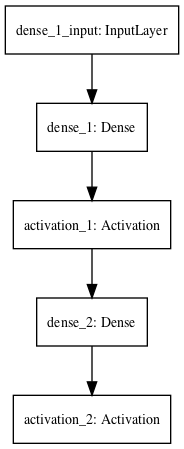

In [23]:
plot_model(model_cat, to_file='Images/model_cat.png')
Image("Images/model_cat.png")

In [24]:
model_cat.fit(X_train_cat, keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=20,
          batch_size=128)

Epoch 1/20
21115/21115 [==============================] - 1s 25us/step - loss: 1.1257 - acc: 0.6632
Epoch 2/20
21115/21115 [==============================] - 0s 14us/step - loss: 0.8455 - acc: 0.7556
Epoch 3/20
21115/21115 [==============================] - 0s 15us/step - loss: 0.7345 - acc: 0.7556
Epoch 4/20
21115/21115 [==============================] - 0s 16us/step - loss: 0.6854 - acc: 0.7556
Epoch 5/20
21115/21115 [==============================] - 0s 15us/step - loss: 0.6575 - acc: 0.7534
Epoch 6/20
21115/21115 [==============================] - 0s 15us/step - loss: 0.6414 - acc: 0.7572
Epoch 7/20
21115/21115 [==============================] - 0s 15us/step - loss: 0.6316 - acc: 0.7590
Epoch 8/20
21115/21115 [==============================] - 0s 14us/step - loss: 0.6254 - acc: 0.7596
Epoch 9/20
21115/21115 [==============================] - 0s 13us/step - loss: 0.6214 - acc: 0.7594
Epoch 10/20
21115/21115 [==============================] - 0s 13us/step - loss: 0.6186 - acc: 0.7600

In [25]:
score = model_cat.evaluate(X_test_cat2, keras.utils.to_categorical(Y_test, num_classes=None), batch_size=128)
score

20966/20966 [==============================] - 0s 8us/step


[0.60327540460142781, 0.7627587522982664]

### Categorical model in way that can be combined with other models
Also see: https://keras.io/getting-started/functional-api-guide/

In [26]:

from keras.layers import Input, Dense
from keras.models import Model
# This returns a tensor
inputs = Input(shape=(41,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(4, activation='relu')(inputs)
x = Dense(4, activation='relu')(x)
x = Dense(4, activation='tanh')(x)
predictions = Dense(4, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['mse','accuracy']) #accuracy
model.fit(X_train_cat, keras.utils.to_categorical(Y_train, num_classes=None),epochs=10) 

Epoch 1/10
21115/21115 [==============================] - 1s 63us/step - loss: 0.8064 - mean_squared_error: 0.1087 - acc: 0.7466
Epoch 2/10
21115/21115 [==============================] - 1s 49us/step - loss: 0.6646 - mean_squared_error: 0.0911 - acc: 0.7614
Epoch 3/10
21115/21115 [==============================] - 1s 57us/step - loss: 0.6304 - mean_squared_error: 0.0866 - acc: 0.7656
Epoch 4/10
21115/21115 [==============================] - 1s 53us/step - loss: 0.6178 - mean_squared_error: 0.0851 - acc: 0.7702
Epoch 5/10
21115/21115 [==============================] - 1s 51us/step - loss: 0.6118 - mean_squared_error: 0.0845 - acc: 0.7712
Epoch 6/10
21115/21115 [==============================] - 1s 56us/step - loss: 0.6087 - mean_squared_error: 0.0842 - acc: 0.7727
Epoch 7/10
21115/21115 [==============================] - 1s 55us/step - loss: 0.6065 - mean_squared_error: 0.0839 - acc: 0.7747
Epoch 8/10
21115/21115 [==============================] - 1s 51us/step - loss: 0.6046 - mean_squa

## Continious model

In [ ]:
#normalize input? log(1+x) - z score? - (x - mu - sigma)


In [73]:
model_con = Sequential()
#model_con.add(Dense(4,input_dim = 7)) 
model_con.add(Dense(4,input_dim = 7,activation = 'relu')) 
#model_con.add(Activation('relu')) #add drop out?
#model_con.add(Activation('softmax')) #add drop out?
#model_con.add(Dense(4)) #4
model_con.add(Dense(40, activation = 'tanh' ))
model_con.add(Dense(40, activation = 'relu' ))
model_con.add(Dense(4, activation = 'softmax' ))
#model_con.add(Activation('softmax')) #add drop out?
#model_con.add(Activation('relu')) #add drop out?

model_con.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical cross # nic: MSE
              metrics=['mse','accuracy'])

In [49]:
model_con.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_12 (Dense)             (None, 40)                200       
_________________________________________________________________
dense_13 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 164       
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(model_con, to_file='Images/model_con.png')
Image("Images/model_con.png")


In [50]:
#show inputdat:

X_train_con
keras.utils.to_categorical(Y_train, num_classes=None)
save_Y_train.head()
save_Y_train['veracity_num'].unique()

# why loss nan -> acc zero
# do I have to normalize x input
# Is y variable in [0,0,0,1] good?


array([2, 1, 3])

In [74]:
model_con.fit(X_train_con, keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=20,
          batch_size=128
         )

Epoch 1/20
21115/21115 [==============================] - 1s 32us/step - loss: nan - mean_squared_error: nan - acc: 0.0038
Epoch 2/20
21115/21115 [==============================] - 0s 14us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 3/20
21115/21115 [==============================] - 0s 15us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 4/20
21115/21115 [==============================] - 0s 15us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 5/20
21115/21115 [==============================] - 0s 15us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 6/20
21115/21115 [==============================] - 0s 15us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 7/20
21115/21115 [==============================] - 0s 14us/step - loss: nan - mean_squared_error: nan - acc: 0.0000e+00
Epoch 8/20
21115/21115 [==============================] - 0s 16us/step - loss: nan - mean_squared_error: nan - acc:

In [ ]:
score_con = model_con.evaluate(X_test_con, keras.utils.to_categorical(Y_test, num_classes=None), batch_size=128)
score_con

# Combined continious and categorical model

In [ ]:
#main_input = Input(shape=(100,), dtype='int32', name='main_input') #Example
#main_input = Input(input_dim=7, dtype='int32', name='Categorial_input') # not working
cat_input = Input(shape=(41,), name='Categorial_input') # not sure whether this is the good shape(X_train_con.shape)
con_input = Input(shape=(7,), name='Continous_input')
#lstm_input = ??

x = keras.layers.concatenate([cat_input, con_input])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(4, activation='softmax', name='main_output')(x) # from example # 1, 3 or 4

In [ ]:
model = Model(inputs=[cat_input, con_input], outputs=[main_output])

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='Images/model_combined.png')
from IPython.display import Image
Image("Images/model_combined.png")


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['mse','accuracy']) # but you need multiple loss function don't you? # categocial!!!!

In [ ]:
model.fit([X_train_cat, X_train_con], keras.utils.to_categorical(Y_train, num_classes=None),
          epochs=50, batch_size=32)

In [ ]:
model_total = Sequential()
model_total.add(Dense(4,input_dim = 7)) 
model_total.add(Activation('relu'))
model_total.add(Dense(4))
model_total.add(Activation('softmax'))

model_total.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', #Nic mse
              metrics=['accuracy','mse'])


In [ ]:
dfg

# For later:

### Stacked LSTM for sequence classification
In this model, we stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.

The first two LSTMs return their full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).



In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
num_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy','mse'])

# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

model.fit(x_train, y_train,
          batch_size=64, epochs=5,
          validation_data=(x_val, y_val))

